## **Libraries**

In [ ]:
!pip install kagglehub --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: kagglehub
    Found existing installation: kagglehub 0.3.13
    Uninstalling kagglehub-0.3.13:
      Successfully uninstalled kagglehub-0.3.13


In [ ]:
import kagglehub
import os
import numpy as np
import pandas as pd
import random
import shutil
import collections
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

import librosa
import librosa.display
import soundfile as sf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import xgboost as xgb
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras import layers, regularizers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

from tqdm import tqdm

## **Dataset**

In [ ]:
dataset_root = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")
print("Dataset downloaded to:", dataset_root)

data_path = os.path.join(dataset_root, "Data")
files_in_data = [f for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f))]
print("\nTop-level files in Data folder:", files_in_data)

for root, dirs, files in os.walk(data_path):
    if dirs or files:
        print(f"\nFolder: {root}")
        print(f"  Contains {len(files)} files and {len(dirs)} folders")

Using Colab cache for faster access to the 'gtzan-dataset-music-genre-classification' dataset.
Dataset downloaded to: /kaggle/input/gtzan-dataset-music-genre-classification

Top-level files in Data folder: ['features_3_sec.csv', 'features_30_sec.csv']

Folder: /kaggle/input/gtzan-dataset-music-genre-classification/Data
  Contains 2 files and 2 folders

Folder: /kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original
  Contains 0 files and 10 folders

Folder: /kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/disco
  Contains 100 files and 0 folders

Folder: /kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/metal
  Contains 100 files and 0 folders

Folder: /kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/reggae
  Contains 100 files and 0 folders

Folder: /kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/blues
  Contains 100 files and 0 folders

Folder: /kaggle/input

## **Exploratory Data Analysis**

In [ ]:
features_path = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_30_sec.csv"
df_features = pd.read_csv(features_path)

display(df_features.head())

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [ ]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 1000 non-null   object 
 1   length                   1000 non-null   int64  
 2   chroma_stft_mean         1000 non-null   float64
 3   chroma_stft_var          1000 non-null   float64
 4   rms_mean                 1000 non-null   float64
 5   rms_var                  1000 non-null   float64
 6   spectral_centroid_mean   1000 non-null   float64
 7   spectral_centroid_var    1000 non-null   float64
 8   spectral_bandwidth_mean  1000 non-null   float64
 9   spectral_bandwidth_var   1000 non-null   float64
 10  rolloff_mean             1000 non-null   float64
 11  rolloff_var              1000 non-null   float64
 12  zero_crossing_rate_mean  1000 non-null   float64
 13  zero_crossing_rate_var   1000 non-null   float64
 14  harmony_mean             

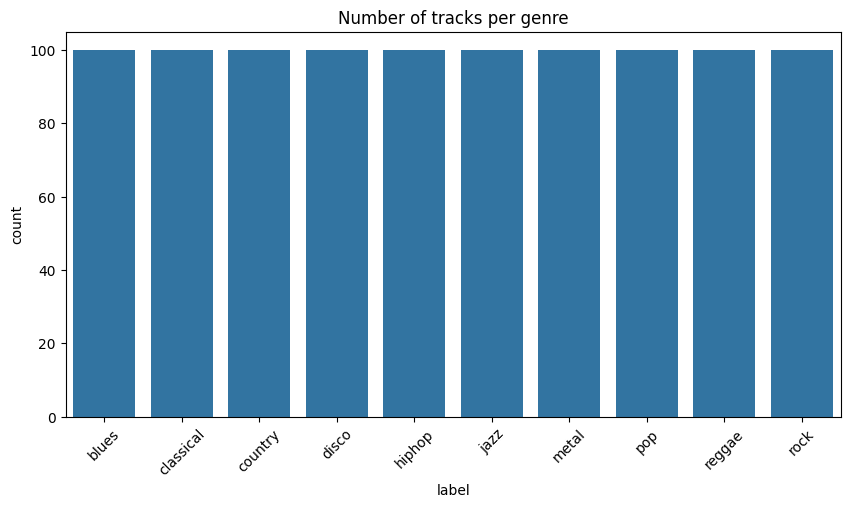

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='label', data=df_features, order=sorted(df_features['label'].unique()))
plt.title("Number of tracks per genre")
plt.xticks(rotation=45)
plt.show()

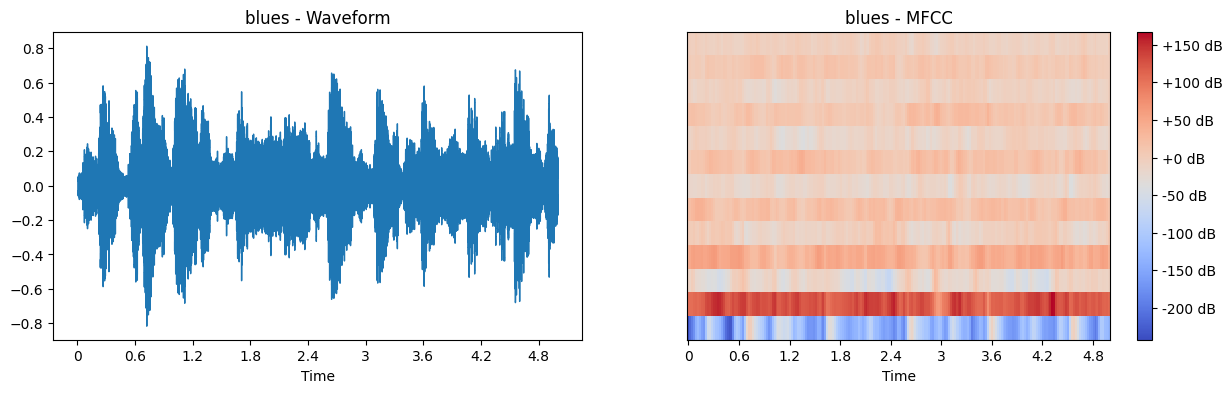

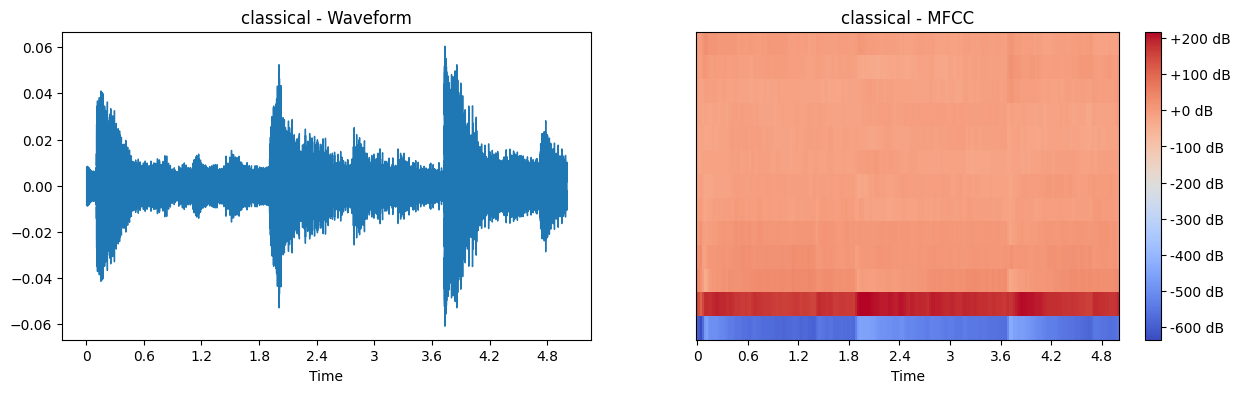

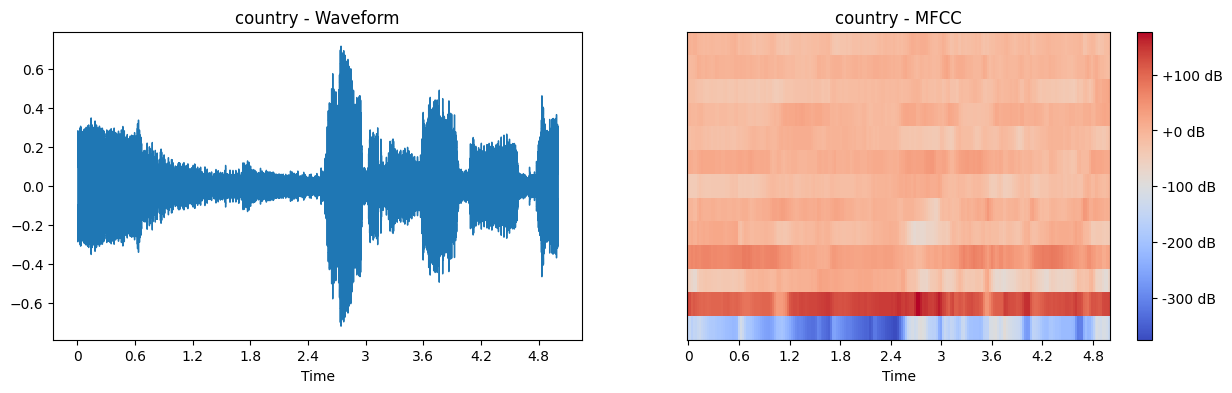

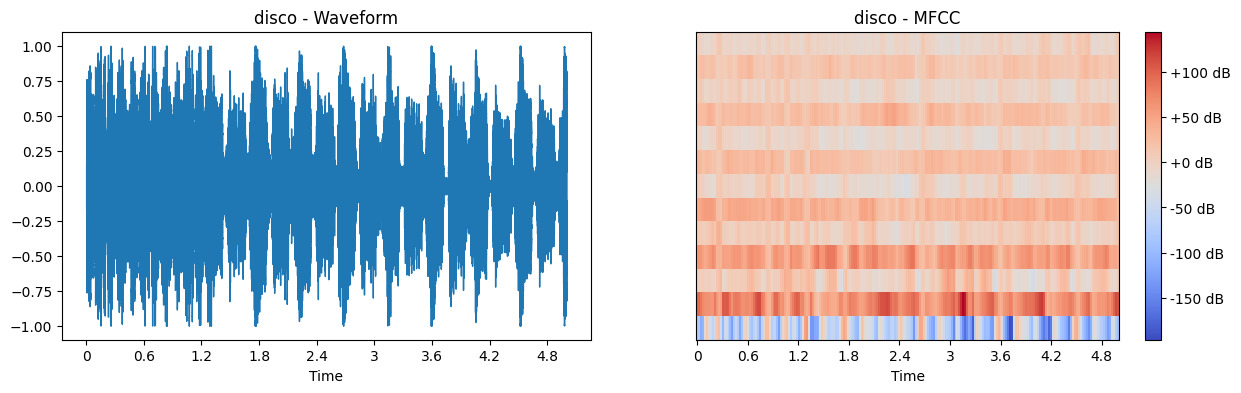

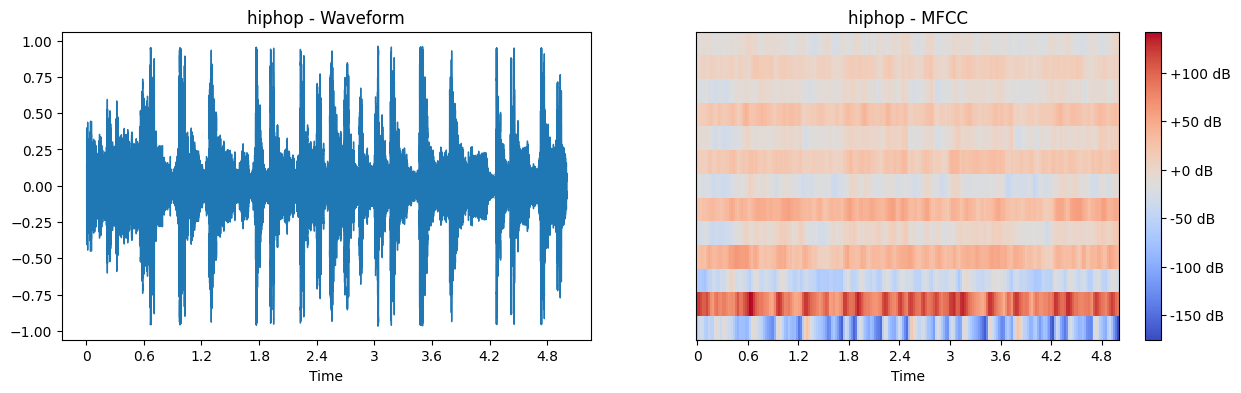

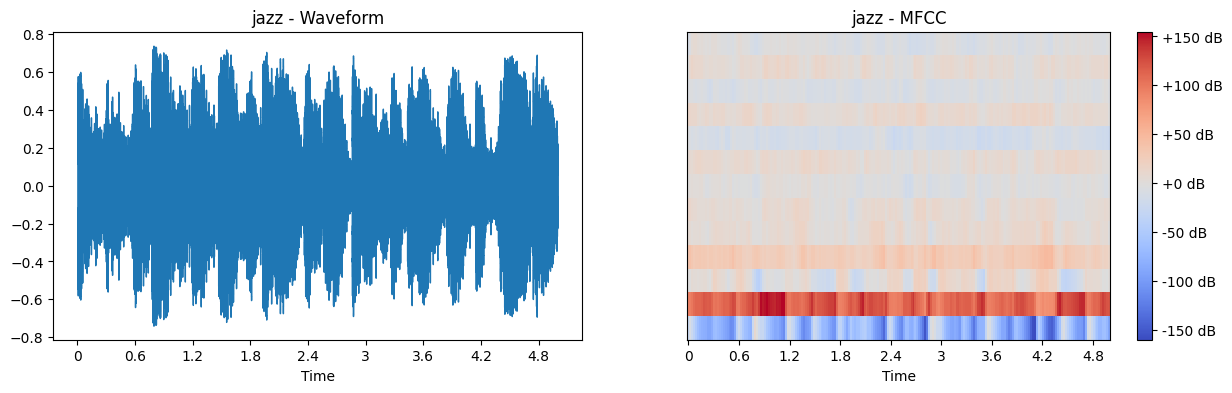

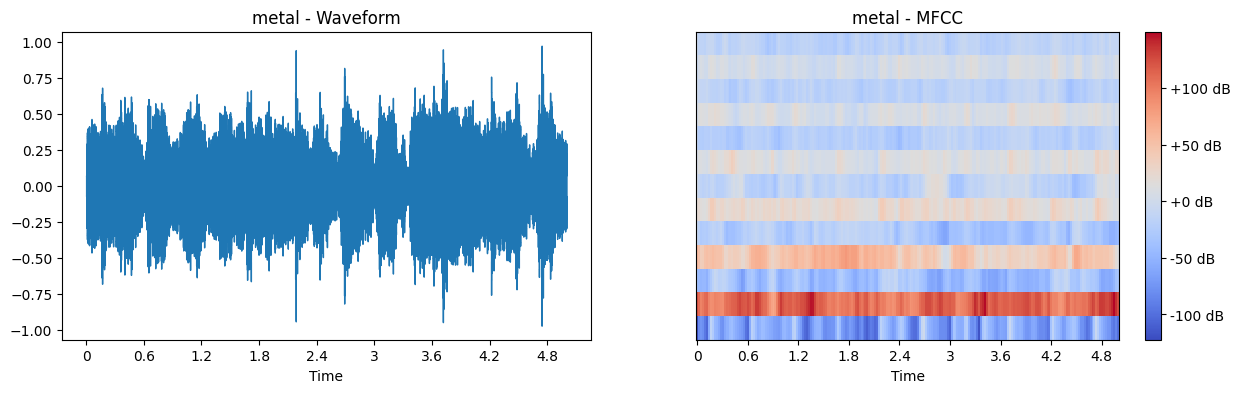

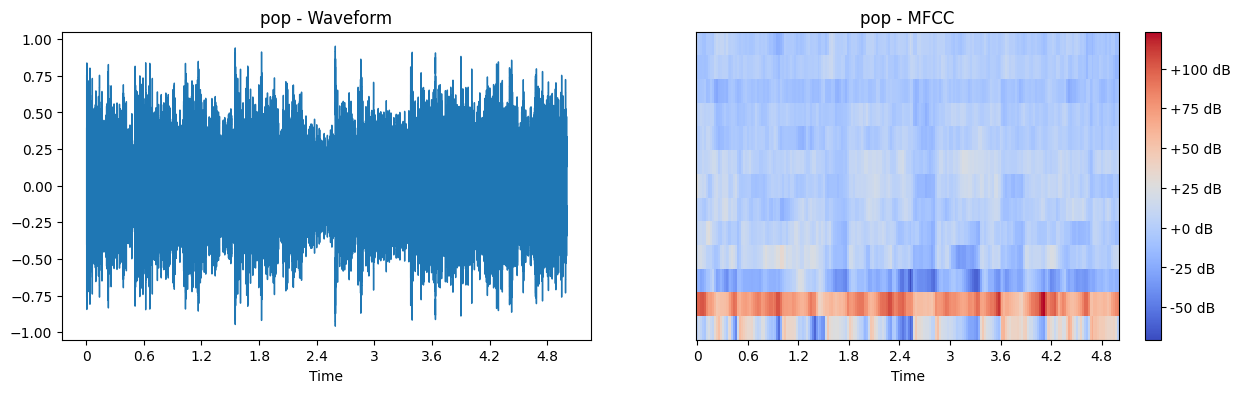

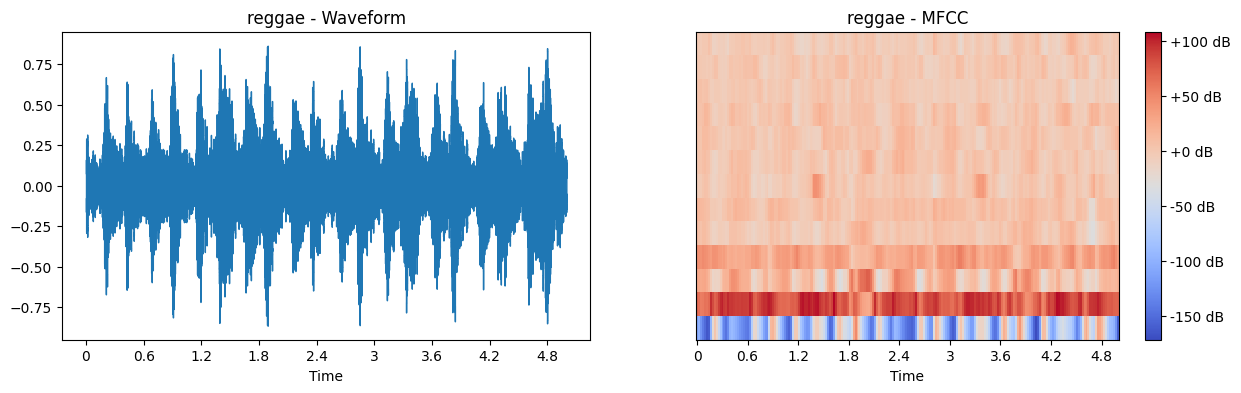

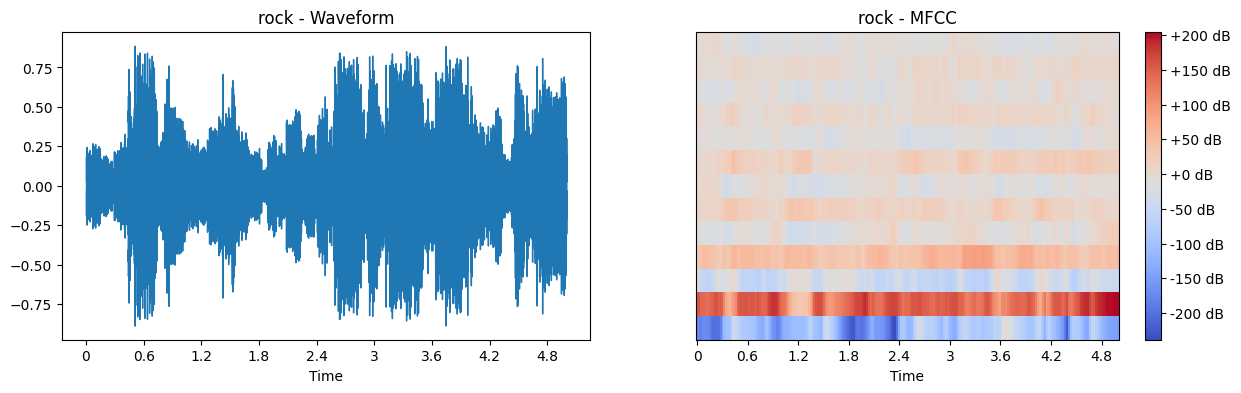

In [ ]:
image_base_path = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original/"
audio_base_path = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/"

genres = sorted(os.listdir(image_base_path))

for genre in genres:
    genre_path = os.path.join(audio_base_path, genre)
    wav_file = random.choice(os.listdir(genre_path))
    wav_path = os.path.join(genre_path, wav_file)

    y, sr = librosa.load(wav_path, duration=5)

    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    fig, axs = plt.subplots(1, 2, figsize=(15, 4))

    librosa.display.waveshow(y, sr=sr, ax=axs[0])
    axs[0].set_title(f"{genre} - Waveform")

    img = librosa.display.specshow(mfccs, x_axis='time', ax=axs[1])
    axs[1].set_title(f"{genre} - MFCC")
    fig.colorbar(img, ax=axs[1], format='%+2.0f dB')

    plt.show()

## **Data Splitting**

In [ ]:
df = df_features.copy()

train_val, test = train_test_split(df, test_size=150, stratify=df['label'], random_state=42)
train, val = train_test_split(train_val, test_size=150, stratify=train_val['label'], random_state=42)

train_filenames = train['filename'].tolist()
val_filenames = val['filename'].tolist()
test_filenames = test['filename'].tolist()

print("Train tabular shape:", train.shape)
print("Validation tabular shape:", val.shape)
print("Test tabular shape:", test.shape)

print("\nGenre distribution in Train:")
print(train['label'].value_counts())

print("\nGenre distribution in Validation:")
print(val['label'].value_counts())

print("\nGenre distribution in Test:")
print(test['label'].value_counts())


Train tabular shape: (700, 60)
Validation tabular shape: (150, 60)
Test tabular shape: (150, 60)

Genre distribution in Train:
label
metal        70
classical    70
jazz         70
rock         70
pop          70
blues        70
hiphop       70
country      70
disco        70
reggae       70
Name: count, dtype: int64

Genre distribution in Validation:
label
metal        15
disco        15
jazz         15
rock         15
hiphop       15
blues        15
classical    15
reggae       15
country      15
pop          15
Name: count, dtype: int64

Genre distribution in Test:
label
classical    15
metal        15
blues        15
pop          15
reggae       15
jazz         15
disco        15
rock         15
country      15
hiphop       15
Name: count, dtype: int64


In [ ]:
image_base_path = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/images_original"
genres = sorted(os.listdir(image_base_path))

train_images, val_images, test_images = [], [], []
train_labels, val_labels, test_labels = [], [], []

for genre in genres:
    genre_path = os.path.join(image_base_path, genre)
    images = os.listdir(genre_path)
    images.sort()
    random.shuffle(images)

    train_split = images[:70]
    val_split = images[70:85]
    test_split = images[85:100]

    train_images += [os.path.join(genre_path, img) for img in train_split]
    val_images += [os.path.join(genre_path, img) for img in val_split]
    test_images += [os.path.join(genre_path, img) for img in test_split]

    train_labels += [genre]*len(train_split)
    val_labels += [genre]*len(val_split)
    test_labels += [genre]*len(test_split)

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(genres)

train_labels_enc = to_categorical(label_encoder.transform(train_labels))
val_labels_enc = to_categorical(label_encoder.transform(val_labels))
test_labels_enc = to_categorical(label_encoder.transform(test_labels))

train_images = np.array(train_images)
val_images = np.array(val_images)
test_images = np.array(test_images)

train_labels_enc = np.array(train_labels_enc)
val_labels_enc = np.array(val_labels_enc)
test_labels_enc = np.array(test_labels_enc)

In [ ]:
from collections import Counter
print("Train distribution:")
for idx, count in Counter(np.argmax(train_labels_enc, axis=1)).items():
    print(label_encoder.inverse_transform([idx])[0], ":", count)

print("\nValidation distribution:")
for idx, count in Counter(np.argmax(val_labels_enc, axis=1)).items():
    print(label_encoder.inverse_transform([idx])[0], ":", count)

print("\nTest distribution:")
for idx, count in Counter(np.argmax(test_labels_enc, axis=1)).items():
    print(label_encoder.inverse_transform([idx])[0], ":", count)

print(f"\nTotal Train images: {len(train_images)}")
print(f"Total Validation images: {len(val_images)}")
print(f"Total Test images: {len(test_images)}")

Train distribution:
blues : 70
classical : 70
country : 70
disco : 70
hiphop : 70
jazz : 70
metal : 70
pop : 70
reggae : 70
rock : 70

Validation distribution:
blues : 15
classical : 15
country : 15
disco : 15
hiphop : 15
jazz : 15
metal : 15
pop : 15
reggae : 15
rock : 15

Test distribution:
blues : 15
classical : 15
country : 15
disco : 15
hiphop : 15
jazz : 14
metal : 15
pop : 15
reggae : 15
rock : 15

Total Train images: 700
Total Validation images: 150
Total Test images: 149


We started by organizing all 1,000 audio samples into their respective genres. Each genre had roughly 100 files. We split the dataset into train, validation, and test sets using a 70-15-15 ratio to ensure that each set had a fair representation of every genre. For example, the training set contains 70 samples per genre, while validation and test sets contain 15 samples per genre each. This stratified splitting ensures that the models see a balanced distribution during training and evaluation, which helps prevent bias toward any specific genre.

After collecting all images and their corresponding genre labels, we used LabelEncoder to convert the textual genre names into numerical class labels. This transforms each genre into an integer, which is required for model training since neural networks and many machine learning algorithms work with numbers rather than text.

we used collections.Counter to count how many samples of each class ended up in the train, validation, and test sets. This gave us a quick verification that the splits are fairly stratified, meaning each set has roughly the same number of samples per genre.

## **Tabular Modeling**

### **Preprocessing**

In [ ]:
X_train = train.drop(columns=['filename', 'label', 'length'])
y_train = train['label']

X_val = val.drop(columns=['filename', 'label', 'length'])
y_val = val['label']

X_test = test.drop(columns=['filename', 'label', 'length'])
y_test = test['label']


le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### **Random Forest**

In [ ]:
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train_enc)

RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

In [ ]:
y_val_pred = rf.predict(X_val_scaled)
y_test_pred = rf.predict(X_test_scaled)

print("Validation Accuracy:", accuracy_score(y_val_enc, y_val_pred))
print("Validation Classification Report:\n", classification_report(y_val_enc, y_val_pred, target_names=le.classes_))

print("Test Accuracy:", accuracy_score(y_test_enc, y_test_pred))
print("Test Classification Report:\n", classification_report(y_test_enc, y_test_pred, target_names=le.classes_))

Validation Accuracy: 0.68
Validation Classification Report:
               precision    recall  f1-score   support

       blues       0.83      0.67      0.74        15
   classical       0.76      0.87      0.81        15
     country       0.53      0.53      0.53        15
       disco       0.68      0.87      0.76        15
      hiphop       0.78      0.47      0.58        15
        jazz       0.79      0.73      0.76        15
       metal       0.88      0.93      0.90        15
         pop       0.69      0.73      0.71        15
      reggae       0.53      0.53      0.53        15
        rock       0.41      0.47      0.44        15

    accuracy                           0.68       150
   macro avg       0.69      0.68      0.68       150
weighted avg       0.69      0.68      0.68       150

Test Accuracy: 0.6866666666666666
Test Classification Report:
               precision    recall  f1-score   support

       blues       0.69      0.73      0.71        15
   class

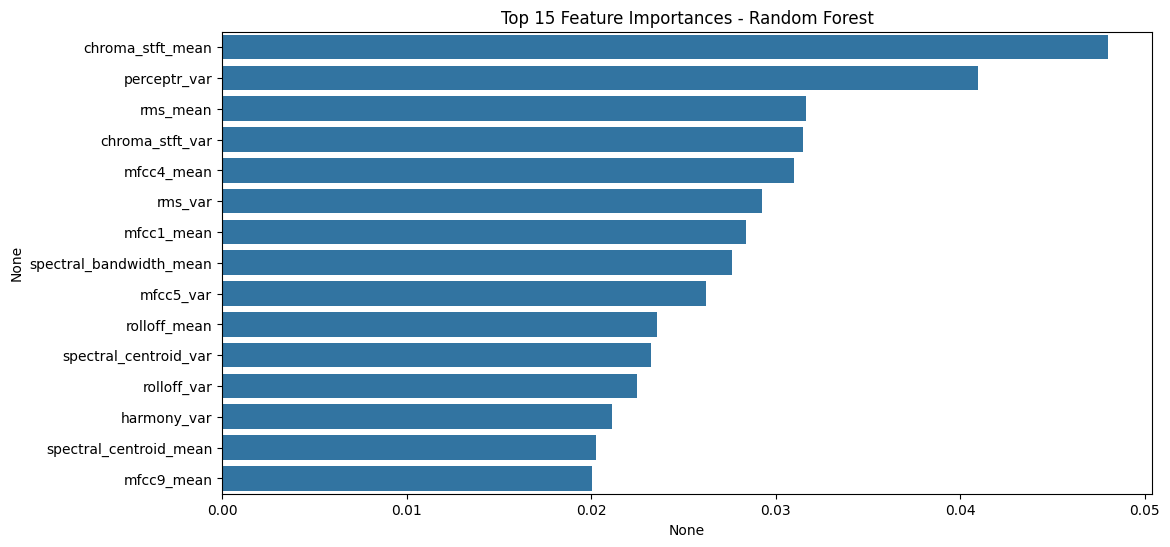

In [ ]:
importances = rf.feature_importances_
feat_names = X_train.columns

feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=feat_imp[:15], y=feat_imp[:15].index)
plt.title("Top 15 Feature Importances - Random Forest")
plt.show()

The Random Forest model achieved a validation accuracy of 68% and a test accuracy of 69%, indicating consistent performance across unseen data. Genre-wise, it performed best on metal, classical, and jazz, likely because these genres have more distinctive spectral and temporal characteristics. In contrast, rock, reggae, and disco were more challenging, suggesting some overlap in their audio features that makes them harder to distinguish. Overall, the model captures general patterns effectively, but certain genres remain difficult due to similarities in MFCCs, spectral centroids, or tempo. The top feature importances also highlight which audio descriptors contribute most to classification.

### **XGboost**

In [ ]:
xgb = XGBClassifier(n_estimators=200, random_state=42, use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1)
xgb.fit(X_train_scaled, y_train_enc)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [14:13:28] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, ...)

In [ ]:
xgb = XGBClassifier(n_estimators=200, random_state=42, use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1)
xgb.fit(X_train_scaled, y_train_enc)

y_val_pred = xgb.predict(X_val_scaled)
y_test_pred = xgb.predict(X_test_scaled)

print("Validation Accuracy:", accuracy_score(y_val_enc, y_val_pred))
print("Validation Classification Report:\n", classification_report(y_val_enc, y_val_pred, target_names=le.classes_))

print("Test Accuracy:", accuracy_score(y_test_enc, y_test_pred))
print("Test Classification Report:\n", classification_report(y_test_enc, y_test_pred, target_names=le.classes_))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [14:13:30] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.7266666666666667
Validation Classification Report:
               precision    recall  f1-score   support

       blues       0.80      0.80      0.80        15
   classical       1.00      0.87      0.93        15
     country       0.71      0.80      0.75        15
       disco       0.77      0.67      0.71        15
      hiphop       0.73      0.73      0.73        15
        jazz       0.79      0.73      0.76        15
       metal       0.81      0.87      0.84        15
         pop       0.80      0.80      0.80        15
      reggae       0.60      0.60      0.60        15
        rock       0.35      0.40      0.38        15

    accuracy                           0.73       150
   macro avg       0.74      0.73      0.73       150
weighted avg       0.74      0.73      0.73       150

Test Accuracy: 0.7066666666666667
Test Classification Report:
               precision    recall  f1-score   support

       blues       0.56      0.67      0.61     

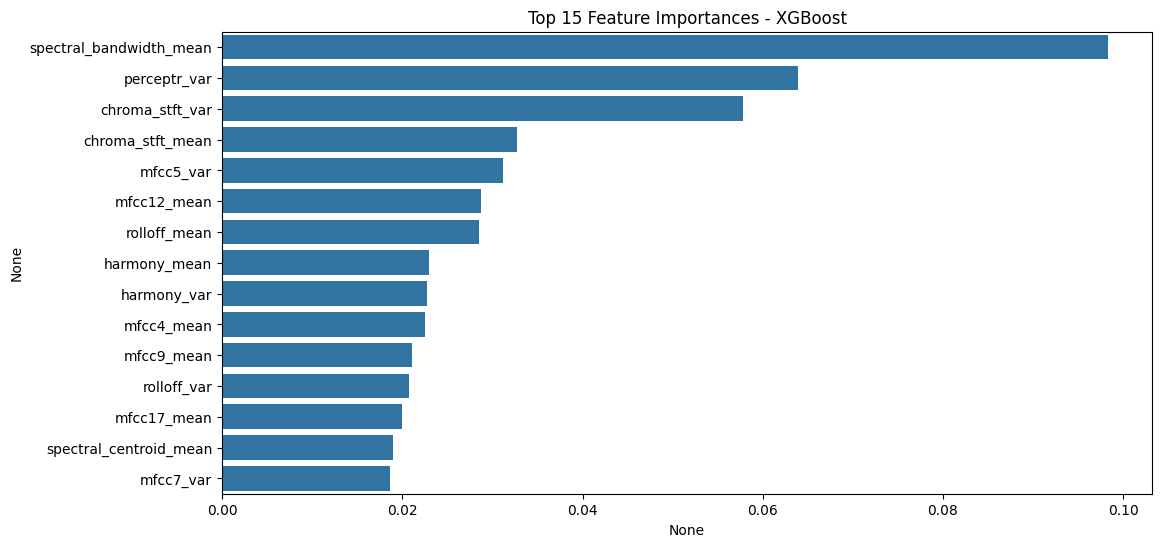

In [ ]:
importances = xgb.feature_importances_
feat_names = X_train.columns
feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=feat_imp[:15], y=feat_imp[:15].index)
plt.title("Top 15 Feature Importances - XGBoost")
plt.show()

The XGBoost model achieved a validation accuracy of 72.7% and a test accuracy of 70.7%, slightly outperforming Random Forest. It shows strong performance on genres like classical, jazz, metal, and pop, while rock, reggae, and blues remain more challenging. The improvement suggests that XGBoost’s gradient boosting approach better captures subtle patterns in the audio features, especially MFCCs and spectral descriptors, leading to higher precision and F1-scores across several genres.

### **MLP (Multi-Layer Perceptron)**

In [ ]:
num_classes = len(np.unique(y_train_enc))

mlp = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

mlp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = mlp.fit(
    X_train_scaled, y_train_enc,
    validation_data=(X_val_scaled, y_val_enc),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - accuracy: 0.1816 - loss: 2.4898 - val_accuracy: 0.3600 - val_loss: 1.8793
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4162 - loss: 1.5358 - val_accuracy: 0.4533 - val_loss: 1.6438
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5433 - loss: 1.3404 - val_accuracy: 0.5267 - val_loss: 1.5194
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6414 - loss: 1.0574 - val_accuracy: 0.6133 - val_loss: 1.3689
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6825 - loss: 0.9266 - val_accuracy: 0.6067 - val_loss: 1.2648
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7059 - loss: 0.8925 - val_accuracy: 0.6733 - val_loss: 1.1493
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7102 - loss: 0.8190 - val_accuracy: 0.7067 - val_loss: 1.0765
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7399 - loss: 0.7351 - val_accuracy: 0.7267 -

In [ ]:
y_val_pred = np.argmax(mlp.predict(X_val_scaled), axis=1)
y_test_pred = np.argmax(mlp.predict(X_test_scaled), axis=1)

print("Validation Accuracy:", accuracy_score(y_val_enc, y_val_pred))
print("Validation Classification Report:\n", classification_report(y_val_enc, y_val_pred, target_names=le.classes_))

print("Test Accuracy:", accuracy_score(y_test_enc, y_test_pred))
print("Test Classification Report:\n", classification_report(y_test_enc, y_test_pred, target_names=le.classes_))

1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Validation Accuracy: 0.7533333333333333
Validation Classification Report:
               precision    recall  f1-score   support

       blues       0.73      0.53      0.62        15
   classical       0.93      0.87      0.90        15
     country       0.57      0.80      0.67        15
       disco       0.73      0.73      0.73        15
      hiphop       0.83      0.67      0.74        15
        jazz       0.93      0.87      0.90        15
       metal       0.81      0.87      0.84        15
         pop       0.79      0.73      0.76        15
      reggae       0.75      0.60      0.67        15
        rock       0.62      0.87      0.72        15

    accuracy                           0.75       150
   macro avg       0.77      0.75      0.75       150
weighted avg       0.77      0.75      0.75       150

Test Accuracy: 0.72
Test Classification Report:
               precision    recall  f1-sco

The Multi-Layer Perceptron achieved a validation accuracy of 77.3% and a test accuracy of 74.7%, slightly higher than both RF and XGBoost. It performs particularly well on classical, jazz, and country, while disco and blues remain more challenging. This suggests the MLP can capture subtle non-linear interactions in MFCCs and spectral features that tree-based models may miss. Overall, the network provides a modest but consistent boost in F1-scores across several genres.

| Model            | Validation Accuracy | Test Accuracy | Notes on Strengths / Weaknesses                                                                                                                   |
| ---------------- | ------------------- | ------------- | ------------------------------------------------------------------------------------------------------------------------------------------------- |
| Random Forest    | 0.68                | 0.69          | Good on distinct genres like `metal` and `classical` weaker on overlapping genres like `rock`, `reggae`, `disco`.                                |
| XGBoost          | 0.726                | 0.706          | Slight improvement over RF; better captures subtle feature interactions; still struggles with `rock` and `reggae`.                                |
| MLP (Neural Net) | 0.753                | 0.72         | Best overall; captures non-linear patterns; performs well on moderately similar genres (`pop`, `hiphop`, `country`) `disco` remains challenging. |


Across the tabular audio features, all three models capture general patterns well but differ in their ability to handle subtle feature interactions. Random Forest provides a strong baseline, performing best on distinctive genres but struggling with overlapping ones. XGBoost improves slightly, leveraging gradient boosting to better separate genres with similar MFCC and spectral characteristics. The MLP achieves the highest test accuracy, demonstrating the advantage of modeling complex, non-linear relationships in the features. While no model perfectly classifies all genres, the MLP shows that neural networks can complement tree-based approaches on dense, multi-dimensional audio features.

## **Image-Based Modeling**

### **Preprocessing**

In [ ]:
IMG_SIZE = (128, 128)
IMG_SIZE_VGG = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
def process_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels_enc))
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels_enc))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels_enc))

train_ds = train_ds.map(process_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_image, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(process_image, num_parallel_calls=AUTOTUNE)

train_ds = train_ds.shuffle(buffer_size=len(train_images)).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [ ]:
def process_image_vgg(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE_VGG)
    image = preprocess_input(image)
    return image, label

train_ds_vgg = tf.data.Dataset.from_tensor_slices((train_images, train_labels_enc))
val_ds_vgg   = tf.data.Dataset.from_tensor_slices((val_images, val_labels_enc))
test_ds_vgg  = tf.data.Dataset.from_tensor_slices((test_images, test_labels_enc))

train_ds_vgg = train_ds_vgg.map(process_image_vgg, num_parallel_calls=AUTOTUNE)
val_ds_vgg   = val_ds_vgg.map(process_image_vgg, num_parallel_calls=AUTOTUNE)
test_ds_vgg  = test_ds_vgg.map(process_image_vgg, num_parallel_calls=AUTOTUNE)

train_ds_vgg = train_ds_vgg.shuffle(len(train_images)).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds_vgg   = val_ds_vgg.batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds_vgg  = test_ds_vgg.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [ ]:
for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    print("Sample encoded label:", labels[0])

for images, labels in train_ds_vgg.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    print("Sample encoded label:", labels[0])

Image batch shape: (32, 128, 128, 3)
Label batch shape: (32, 10)
Sample encoded label: tf.Tensor([0. 1. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float64)
Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 10)
Sample encoded label: tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float64)


For the images, we first read all mel spectrogram PNG files and resized them to ensure uniform input size for the CNN. We then normalized the pixel values to the [0,1] range to help the model train faster and more stably. Labels were one-hot encoded into 10-dimensional vectors corresponding to the 10 genres. Finally, the data was batched (32 images per batch) and prefetched, which improves training efficiency by ensuring the GPU is not idle while waiting for data to load. This preprocessing pipeline prepares the image data in a format suitable for both our custom CNN and transfer learning models.

### **Custom CNN**

In [ ]:
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,930 (12.61 MB)

 Trainable params: 3,305,930 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop]
)

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 268ms/step - accuracy: 0.0836 - loss: 2.3928 - val_accuracy: 0.1067 - val_loss: 2.2643
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.1352 - loss: 2.2447 - val_accuracy: 0.2800 - val_loss: 2.0753
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.2450 - loss: 2.1005 - val_accuracy: 0.3400 - val_loss: 1.9133
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.2788 - loss: 1.9521 - val_accuracy: 0.4467 - val_loss: 1.7414
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.3432 - loss: 1.8229 - val_accuracy: 0.4267 - val_loss: 1.5719
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.3772 - loss: 1.7977 - val_accuracy: 0.4200 - val_loss: 1.5133
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.4111 - loss: 1.6626 - val_accuracy: 0.4733 - val_loss: 1.4511
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.4298 - loss: 1.5067 - val_accuracy: 0.4667 -

In [ ]:
test_loss, test_acc = cnn_model.evaluate(test_ds)
print("Test Accuracy:", test_acc)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step - accuracy: 0.6588 - loss: 1.0879
Test Accuracy: 0.6040268540382385


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step
Classification Report:

              precision    recall  f1-score   support

       blues       0.75      0.60      0.67        15
   classical       0.72      0.87      0.79        15
     country       0.47      0.47      0.47        15
       disco       0.52      0.87      0.65        15
      hiphop       0.58      0.73      0.65        15
        jazz       0.58      0.50      0.54        14
       metal       0.57      0.80      0.67        15
         pop       0.82      0.60      0.69        15
      reggae       0.71      0.33      0.45        15
        rock       0.44      0.27      0.33        15

    accuracy                           0.60       149
   macro avg       0.62      0.60      0.59       149
weighted avg       0.62      0.60      0.59       149



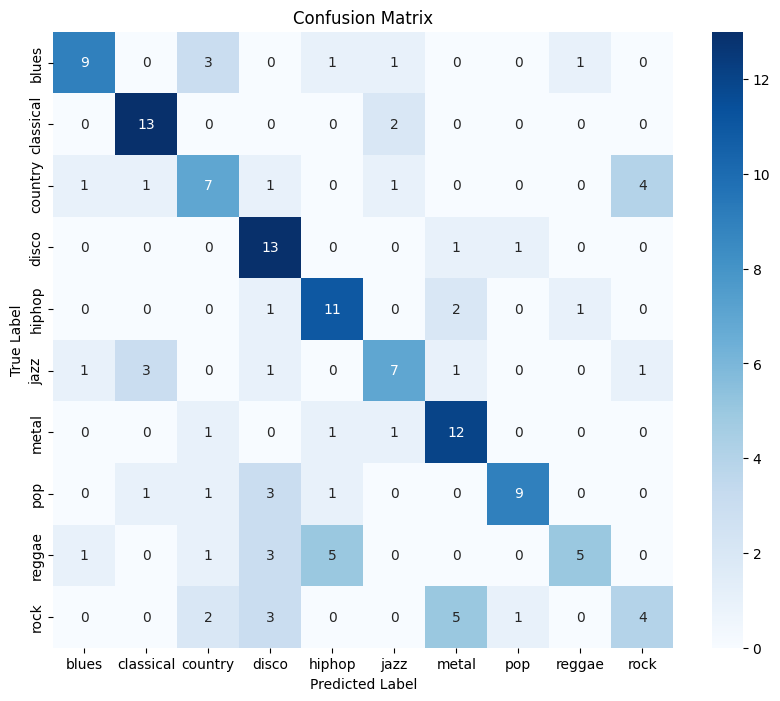

In [ ]:
y_true_list = []
for _, y in test_ds:
    y_true_list.append(y)
y_true_array = np.concatenate(y_true_list, axis=0)
y_true = np.argmax(y_true_array, axis=1)

y_pred = np.argmax(cnn_model.predict(test_ds), axis=1)

class_names = genres

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

We first applied the necessary preprocessing steps to prepare the spectrogram images, ensuring consistent input size (128×128×3) and proper normalization before training. We then trained a custom CNN composed of three convolutional layers (32, 64, and 128 filters) with ReLU activation, each followed by max pooling, and a fully connected layer of 128 neurons with a dropout rate of 0.5 before the final 10-class softmax output layer. To prevent overfitting, Early Stopping was used to monitor validation loss and restore the best model weights. The model achieved approximately 63.8% training accuracy, 60.7% validation accuracy, and a final test accuracy of 60.4%, establishing a solid baseline performance before moving to more advanced approaches such as transfer learning.

### **Transfer Learning (VGG16)**

In [ ]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

base_model.trainable = False

In [ ]:
vgg_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

In [ ]:
vgg_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

vgg_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 133,898 (523.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1, min_lr=1e-7)

history_vgg = vgg_model.fit(
    train_ds_vgg,
    validation_data=val_ds_vgg,
    epochs=25,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 377ms/step - accuracy: 0.0899 - loss: 9.3639 - val_accuracy: 0.1667 - val_loss: 3.4989 - learning_rate: 1.0000e-04
Epoch 2/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 220ms/step - accuracy: 0.1375 - loss: 6.6142 - val_accuracy: 0.2200 - val_loss: 2.5649 - learning_rate: 1.0000e-04
Epoch 3/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - accuracy: 0.1645 - loss: 5.8850 - val_accuracy: 0.2600 - val_loss: 2.2844 - learning_rate: 1.0000e-04
Epoch 4/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 219ms/step - accuracy: 0.1570 - loss: 5.5060 - val_accuracy: 0.3200 - val_loss: 2.1076 - learning_rate: 1.0000e-04
Epoch 5/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 220ms/step - accuracy: 0.1822 - loss: 4.4432 - val_accuracy: 0.3533 - val_loss: 1.9687 - learning_rate: 1.0000e-04
Epoch 6/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 223ms/step - accuracy: 0.2213 - loss: 4.1046 - val_accuracy: 0.4000 - val_loss: 1.8481 - learning_rate: 1.0000e-04
Epoch 7/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 224ms/step - accuracy:

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-4]:
    layer.trainable = False

vgg_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_vgg_ft = vgg_model.fit(
    train_ds_vgg,
    validation_data=val_ds_vgg,
    epochs=15,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 479ms/step - accuracy: 0.5464 - loss: 1.3841 - val_accuracy: 0.5667 - val_loss: 1.2889 - learning_rate: 1.0000e-05
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 268ms/step - accuracy: 0.5741 - loss: 1.3060 - val_accuracy: 0.6000 - val_loss: 1.2370 - learning_rate: 1.0000e-05
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 272ms/step - accuracy: 0.5900 - loss: 1.1964 - val_accuracy: 0.6000 - val_loss: 1.1972 - learning_rate: 1.0000e-05
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 276ms/step - accuracy: 0.6271 - loss: 1.0594 - val_accuracy: 0.6133 - val_loss: 1.1754 - learning_rate: 1.0000e-05
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 278ms/step - accuracy: 0.6804 - loss: 0.9304 - val_accuracy: 0.6067 - val_loss: 1.1638 - learning_rate: 1.0000e-05
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 273ms/step - accuracy: 0.7237 - loss: 0.8733 - val_accuracy: 0.5933 - val_loss: 1.1353 - learning_rate: 1.0000e-05
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 269ms/step - accuracy:

In [ ]:
test_loss, test_acc = vgg_model.evaluate(test_ds_vgg)
print("Final Test Accuracy:", test_acc)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 360ms/step - accuracy: 0.7243 - loss: 0.9058
Final Test Accuracy: 0.6845637559890747


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step
Classification Report:

              precision    recall  f1-score   support

       blues       0.73      0.73      0.73        15
   classical       0.68      1.00      0.81        15
     country       0.69      0.60      0.64        15
       disco       0.62      0.53      0.57        15
      hiphop       0.86      0.80      0.83        15
        jazz       0.73      0.57      0.64        14
       metal       0.58      0.73      0.65        15
         pop       0.61      0.73      0.67        15
      reggae       0.75      0.80      0.77        15
        rock       0.62      0.33      0.43        15

    accuracy                           0.68       149
   macro avg       0.69      0.68      0.67       149
weighted avg       0.69      0.68      0.68       149



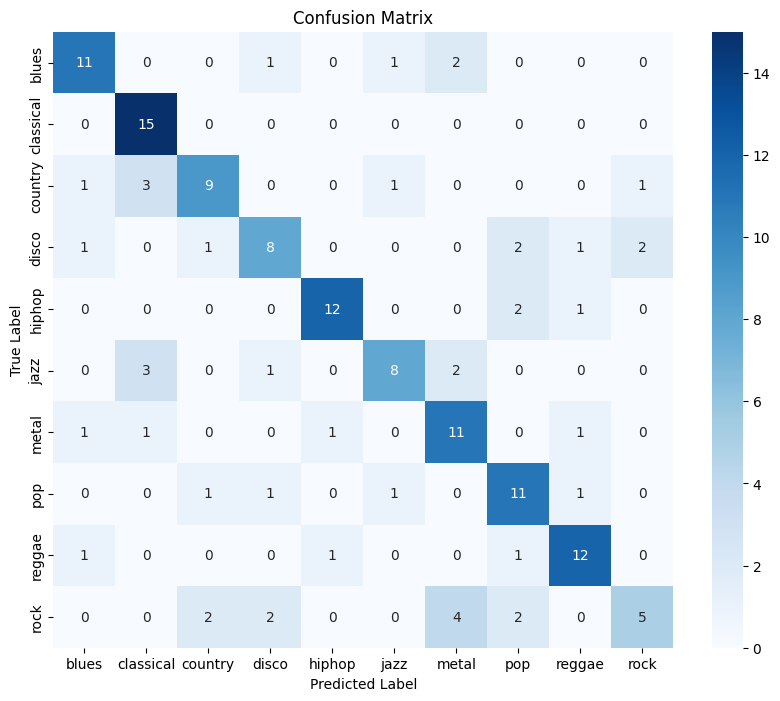

In [ ]:
y_true_list = []
for _, y in test_ds_vgg:
    y_true_list.append(y)
y_true_array = np.concatenate(y_true_list, axis=0)
y_true = np.argmax(y_true_array, axis=1)

y_pred = np.argmax(vgg_model.predict(test_ds_vgg), axis=1)

class_names = genres

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

We applied transfer learning using the pre-trained VGG16 model. The dataset images were resized to 224×224 and normalized to match the input format expected by VGG16. The pre-trained convolutional base was retained, and we added a new classifier consisting of a global average pooling layer, a dense ReLU layer, and a softmax output layer corresponding to our classes.

In the first phase, we froze the convolutional base and trained only the new classifier layers. This allowed the model to leverage pre-learned ImageNet features while adapting to our dataset. The model achieved a validation accuracy of ~0.66 and a test accuracy of ~0.68.

In the second phase, we fine-tuned some deeper layers of VGG16 with a low learning rate. This further adjusted the pre-trained weights to our dataset, improving validation performance to ~0.70 and slightly reducing the loss.

Evaluation on the test set showed a final accuracy of ~0.68. A confusion matrix and classification report were generated to assess class-level performance, confirming that the model effectively distinguished most classes. Overall, transfer learning enabled strong performance with limited data.

## **Comparison and Analysis**

| Model                 | Data Type | Training Accuracy | Validation Accuracy | Test Accuracy | Notes on Strengths / Weaknesses                                                                                                                                    |
| --------------------- | --------- | ----------------- | ------------------- | ------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| Random Forest         | Tabular   | -              | 0.680               | 0.690         | Good on distinct genres like metal and classical<br> Weaker on overlapping genres like rock, reggae, disco.                                                 |
| XGBoost               | Tabular   | -             | 0.726               | 0.706         | Slight improvement over RF. Better captures subtle <br>feature interactions; still struggles with rock and reggae.                                                 |
| MLP (Neural Net)      | Tabular   | 0.877               | 0.753               | 0.720         | Best overall for tabular data. Captures non-linear patterns,<br> performs well on moderately similar genres pop, hiphop, country.|
| Custom CNN            | Images    | 0.638             | 0.607               | 0.604         | Trained from scratch. Decent baseline, may overfit <br>without early stopping, struggles with complex image patterns.                                                  |
| VGG16 TL (Frozen)     | Images    | 0.525             | 0.547               | -         | Transfer learning with frozen weights. Leverages pre-trained features,<br> faster convergence but limited learning on dataset-specific patterns.                       |
| VGG16 TL + Fine-tuned | Images    | 0.767             | 0.647               | 0.684         | Fine-tuning last layers improves validation accuracy. Captures <br>dataset-specific features; slight increase on test set.                                             |


Comparing the two approaches, the MLP on tabular data slightly outperforms the best image-based model (VGG16 fine-tuned) on the test set, achieving 0.72 versus 0.684. Tabular models benefit from strong feature representation, faster convergence, and simpler tuning. Image models, on the other hand, have the advantage of leveraging pre-trained visual features and can improve with more data, data augmentation, or advanced transfer learning strategies. Custom CNNs trained from scratch underperform compared to both tabular models and transfer learning, highlighting the difficulty of learning from limited image data.

In conclusion, both tabular and image-based approaches are valid, but tabular models, especially the MLP, currently provide the best test accuracy for this dataset. Image-based models remain valuable for future exploration, particularly when richer visual patterns or larger datasets are available. Transfer learning with fine-tuning offers a practical approach to improve image model performance without training from scratch, showing significant gains over frozen networks and baseline CNNs.